# 0) Preparación de entorno

In [20]:
# (Opcional) Instalación si la necesitas en un entorno limpio
#!pip install -U pandas numpy scikit-learn matplotlib seaborn imbalanced-learn shap xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Config plot
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Paths
BASE = Path("..")
DATA_PATH = BASE / "data" / "quejas-clientes.csv"


# 1) Carga de datos + diccionario de variables

In [21]:
# Carga de datos
df = pd.read_csv(DATA_PATH)

# Limpieza: columnas inútiles (índice y Complaint ID)
df = df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")], errors="ignore")
if "Complaint ID" in df.columns:
    df = df.drop(columns=["Complaint ID"])

# Parseo de fechas y cálculo de días hasta envío a empresa
if {"Date received", "Date sent to company"}.issubset(df.columns):
    df["Date received"] = pd.to_datetime(df["Date received"], errors="coerce")
    df["Date sent to company"] = pd.to_datetime(df["Date sent to company"], errors="coerce")
    df["days_to_company"] = (df["Date sent to company"] - df["Date received"]).dt.days
    
    # Eliminamos las fechas originales (para evitar fuga y simplificar)
    df = df.drop(columns=["Date received", "Date sent to company"])

# Convertimos a category algunas columnas 
for c in ["Product", "Sub-product", "Issue", "Sub-issue", "Company", "State", "Company response", "Timely response?", "Consumer disputed?"]:
    if c in df.columns:
        df[c] = df[c].astype("category")

for c in ["ZIP code", "days_to_company"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

df.dtypes

Product               category
Sub-product           category
Issue                 category
Sub-issue             category
State                 category
ZIP code                 Int64
Company               category
Company response      category
Timely response?      category
Consumer disputed?    category
days_to_company          Int64
dtype: object

In [22]:
df.head()

,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,days_to_company
0,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,NaN,0
1,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN,0
2,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0
3,Credit card,NaN,Other,NaN,CA,92592,Navy FCU,In progress,Yes,NaN,0
4,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068,Transworld Systems Inc.,In progress,Yes,NaN,0


In [23]:
# Diccionario rápido (borrador, puedes enriquecerlo)
diccionario = {
    "Product": "Producto financiero principal",
    "Sub-product": "Subtipo del producto",
    "Issue": "Motivo principal de la queja (texto)",
    "Sub-issue": "Motivo específico (texto)",
    "State": "Estado (US)",
    "ZIP code": "Código postal",
    "Company": "Empresa implicada",
    "Company response": "Tipo de respuesta de la empresa",
    "Timely response?": "¿Respondió a tiempo? (Yes/No)",
    "Consumer disputed?": "¿El consumidor disputó posteriormente? (Yes/No/NaN)",
    "days_to_company": "Días que tardó la empresa en responder"
}
pd.Series(diccionario)


Product                                   Producto financiero principal
Sub-product                                        Subtipo del producto
Issue                              Motivo principal de la queja (texto)
Sub-issue                                     Motivo específico (texto)
State                                                       Estado (US)
ZIP code                                                  Código postal
Company                                               Empresa implicada
Company response                        Tipo de respuesta de la empresa
Timely response?                          ¿Respondió a tiempo? (Yes/No)
Consumer disputed?    ¿El consumidor disputó posteriormente? (Yes/No...
days_to_company                  Días que tardó la empresa en responder
dtype: object

# 2) Calidad de datos: tamaños, tipos, nulos y valores únicos

In [24]:
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
df.info()

Filas: 28156 | Columnas: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Product             28156 non-null  category
 1   Sub-product         17582 non-null  category
 2   Issue               28154 non-null  category
 3   Sub-issue           13211 non-null  category
 4   State               27735 non-null  category
 5   ZIP code            27876 non-null  Int64   
 6   Company             28156 non-null  category
 7   Company response    28156 non-null  category
 8   Timely response?    28156 non-null  category
 9   Consumer disputed?  6006 non-null   category
 10  days_to_company     28156 non-null  Int64   
dtypes: Int64(2), category(9)
memory usage: 823.2 KB


In [25]:
if "days_to_company" in df:
    print("Tiempo de espera (días):", df["days_to_company"].min(), "→", df["days_to_company"].max())

Tiempo de espera (días): 0 → 64


In [26]:
# Nulos
missing = df.isna().mean().sort_values(ascending=False).to_frame("missing_rate")
missing.style.background_gradient(cmap="Reds")


,missing_rate
Consumer disputed?,0.786688
Sub-issue,0.530793
Sub-product,0.375551
State,0.014952
ZIP code,0.009945
Issue,0.000071
Product,0.000000
Company,0.000000
Company response,0.000000
Timely response?,0.000000


In [27]:
# Cardinalidad de algunas columnas categóricas
for col in ["Product", "Sub-product", "Issue", "Sub-issue", "Company", "State", "Company response"]:
    if col in df.columns:
        print(col, "→", df[col].nunique(), "valores únicos")


Product → 11 valores únicos
Sub-product → 42 valores únicos
Issue → 89 valores únicos
Sub-issue → 46 valores únicos
Company → 1534 valores únicos
State → 59 valores únicos
Company response → 6 valores únicos


# 3) Definición del problema

In [28]:
# Normalización del target a {0,1}
df["target"] = df["Consumer disputed?"].map({"Yes": 1, "No": 0})
print(df["target"].value_counts(dropna=False))
df["target"].isna().mean()

target
NaN    22150
1       4708
0       1298
Name: count, dtype: int64


np.float64(0.7866884500639295)

In [29]:
# Número de filas inicial
before = df.shape[0]

# 1) Eliminar nulos en target
df_no_na = df.dropna(subset=["target"]).copy()
after_na = df_no_na.shape[0]
print(f"Filas eliminadas por NaN en target: {before - after_na}")

# 2) Eliminar duplicados
df_model = df_no_na.drop_duplicates().copy()
after_dupes = df_model.shape[0]
print(f"Filas eliminadas por duplicados: {after_na - after_dupes}")

# Total final
print(f"Filas finales: {after_dupes}")

# Convertimos target a int
df_model["target"] = df_model["target"].astype(int)

Filas eliminadas por NaN en target: 22150
Filas eliminadas por duplicados: 36
Filas finales: 5970


# 4) Feature engineering inicial

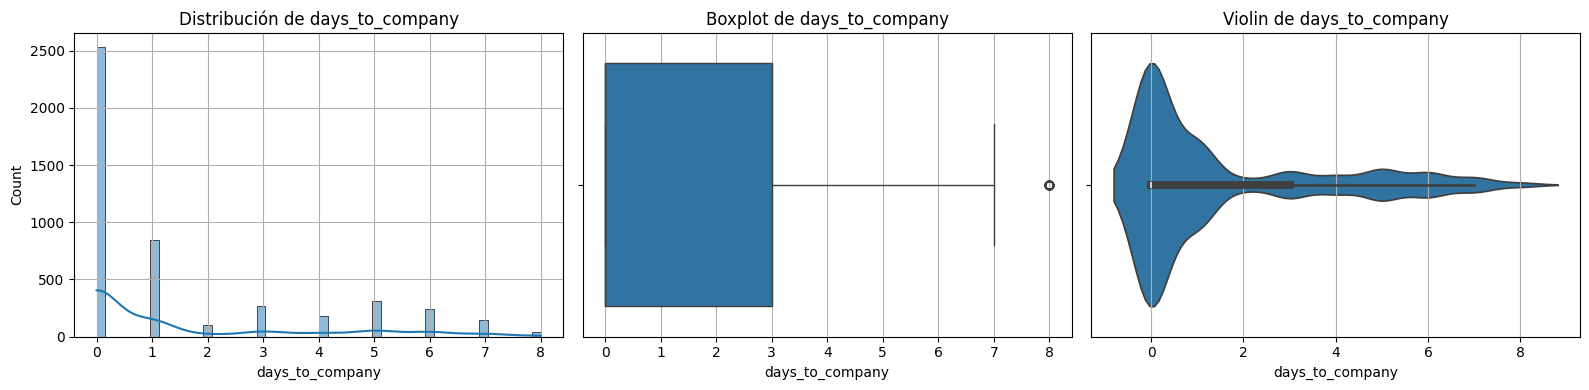

Umbral de outlier (IQR): > 7.50 días (aprox. ≥ 8 días)


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

vals = df_model["days_to_company"].dropna()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histograma
sns.histplot(vals, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribución de days_to_company")
axes[0].set_xlabel("days_to_company")

# Boxplot
sns.boxplot(x=vals, ax=axes[1])
axes[1].set_title("Boxplot de days_to_company")
axes[1].set_xlabel("days_to_company")

# Violin horizontal (girado 90º)
sns.violinplot(x=vals, ax=axes[2])
axes[2].set_title("Violin de days_to_company")
axes[2].set_xlabel("days_to_company")

plt.tight_layout()
plt.show()


# Umbral de outlier por IQR (upper fence)
Q1 = vals.quantile(0.25)
Q3 = vals.quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + 1.5 * IQR

print(f"Umbral de outlier (IQR): > {upper_fence:.2f} días (aprox. ≥ {int(np.ceil(upper_fence))} días)")


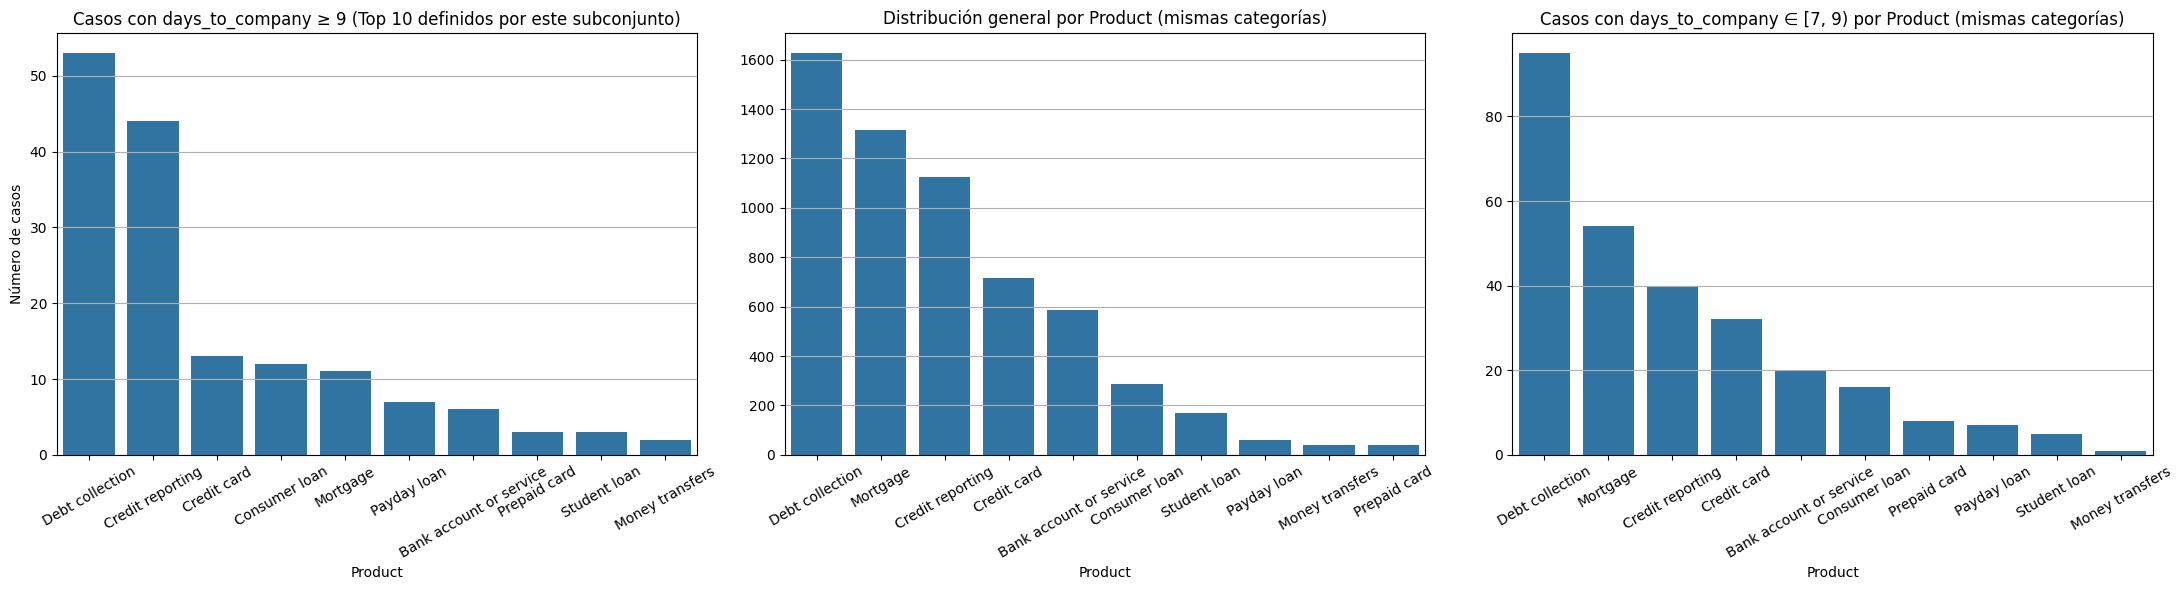

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

THRESH = 9  # umbral para el primer gráfico (>= THRESH)

# Aseguramos que days_to_company es numérico para filtrar con seguridad
df_tmp = df_model.copy()
df_tmp["days_to_company_num"] = pd.to_numeric(df_tmp["days_to_company"], errors="coerce")

# Subconjuntos
df_thr = df_tmp[df_tmp["days_to_company_num"] >= THRESH].copy()                   # >= THRESH
df_win = df_tmp[(df_tmp["days_to_company_num"] >= 7) & (df_tmp["days_to_company_num"] < 9)].copy()  # [7, 9)

# Top 10 productos DEFINIDOS por el subconjunto >= THRESH
top_products = (df_thr["Product"]
                .astype(str)
                .value_counts()
                .head(10)
                .index
                .tolist())

def counts_for_subset(df_subset, products):
    """Devuelve conteos por Product SOLO para la lista 'products', ordenado descendente por 'count'."""
    s = (df_subset[df_subset["Product"].astype(str).isin(products)]["Product"]
         .astype(str)
         .value_counts())
    # reindex para incluir productos ausentes con 0 y luego ordenar por count
    s = s.reindex(products, fill_value=0).sort_values(ascending=False)
    out = s.reset_index()
    out.columns = ["Product", "count"]
    return out

# Conteos para cada vista
counts_thr = counts_for_subset(df_thr, top_products)  # >= THRESH
counts_all = counts_for_subset(df_tmp, top_products)  # general
counts_win = counts_for_subset(df_win, top_products)  # [7, 9)

# Orden explícito (descendente) para cada gráfico
order_thr = counts_thr.sort_values("count", ascending=False)["Product"]
order_all = counts_all.sort_values("count", ascending=False)["Product"]
order_win = counts_win.sort_values("count", ascending=False)["Product"]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=False)

# 1) >= THRESH
sns.barplot(data=counts_thr, x="Product", y="count", order=order_thr, ax=axes[0])
axes[0].set_title(f"Casos con days_to_company ≥ {THRESH} (Top 10 definidos por este subconjunto)")
axes[0].set_xlabel("Product")
axes[0].set_ylabel("Número de casos")
axes[0].tick_params(axis="x", rotation=30)

# 2) Distribución general (mismas categorías, orden descendente propio)
sns.barplot(data=counts_all, x="Product", y="count", order=order_all, ax=axes[1])
axes[1].set_title("Distribución general por Product (mismas categorías)")
axes[1].set_xlabel("Product")
axes[1].set_ylabel("")
axes[1].tick_params(axis="x", rotation=30)

# 3) Ventana [7, 9)
sns.barplot(data=counts_win, x="Product", y="count", order=order_win, ax=axes[2])
axes[2].set_title("Casos con days_to_company ∈ [7, 9) por Product (mismas categorías)")
axes[2].set_xlabel("Product")
axes[2].set_ylabel("")
axes[2].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


In [32]:
# Conteo inicial
before = len(df_model)

# Aseguramos tipo numérico y construimos máscara de eliminación
d2c = pd.to_numeric(df_model["days_to_company"], errors="coerce")
mask_remove = d2c >= 9

# Cuántas se eliminan
removed = int(mask_remove.sum())

# Filtrado in-place (sobrescribimos df_model)
df_model = df_model.loc[~mask_remove].copy()

# Conteo final
after = len(df_model)

print(f"Filas antes: {before}")
print(f"Eliminadas (days_to_company ≥ 9): {removed} ({removed/before:.2%})")
print(f"Filas después: {after}")

Filas antes: 5970
Eliminadas (days_to_company ≥ 9): 155 (2.60%)
Filas después: 5815


Filas totales en el dataset: 5815
Filas representadas por el Top 100: 4678 (80.45%)
Empresa en la posición #100: ECMC Group, Inc. con 6 quejas


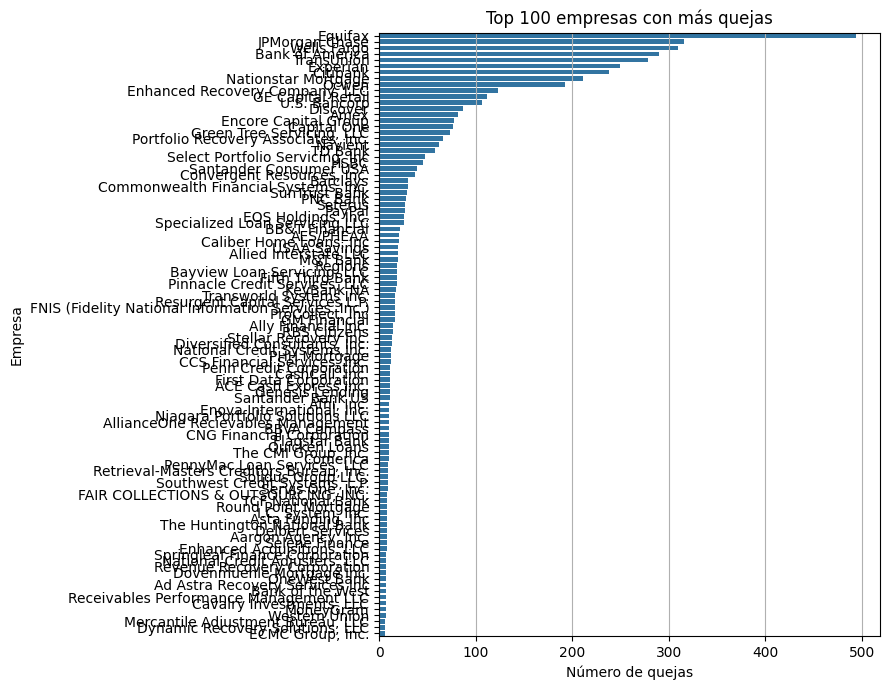

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

N = 100  # <-- cambia aquí cuántas empresas quieres ver

company_counts = df_model["Company"].astype(str).value_counts()
top_companies = company_counts.head(N).reset_index()
top_companies.columns = ["Company", "count"]

total_rows = len(df_model)
top_sum = int(top_companies["count"].sum())
coverage_pct = 100.0 * top_sum / total_rows if total_rows > 0 else 0.0

print(f"Filas totales en el dataset: {total_rows}")
print(f"Filas representadas por el Top {N}: {top_sum} ({coverage_pct:.2f}%)")

# Info de la última empresa dentro del Top N
last_company = top_companies.iloc[-1]
print(f"Empresa en la posición #{N}: {last_company['Company']} con {int(last_company['count'])} quejas")

plt.figure(figsize=(9, 7))
sns.barplot(data=top_companies, y="Company", x="count")
plt.title(f"Top {N} empresas con más quejas")
plt.xlabel("Número de quejas")
plt.ylabel("Empresa")
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd

N = 100  # <-- ajusta aquí el Top N

# Top N compañías por frecuencia
top_list = (df_model["Company"]
            .astype(str)
            .value_counts()
            .head(N)
            .index
            .tolist())

# Filtrado y métricas
before = len(df_model)
mask_keep = df_model["Company"].astype(str).isin(top_list)
removed = int((~mask_keep).sum())

df_model = df_model.loc[mask_keep].copy()
after = len(df_model)

print(f"Filas antes: {before}")
print(f"Eliminadas (Company fuera del Top {N}): {removed} ({removed/before:.2%})")
print(f"Filas después: {after}")

# (Opcional) si Company es 'category', limpiar categorías no usadas para ahorrar memoria
if pd.api.types.is_categorical_dtype(df_model["Company"]):
    df_model["Company"] = df_model["Company"].cat.remove_unused_categories()


Filas antes: 5815
Eliminadas (Company fuera del Top 100): 1137 (19.55%)
Filas después: 4678


C:\Users\pc\AppData\Local\Temp\ipykernel_3972\2285955765.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_model["Company"]):


In [35]:
#!pip install geopandas

In [36]:
# Si no tienes plotly instalado, descomenta la siguiente línea:
#!pip install plotly
#!pip install -U nbformat

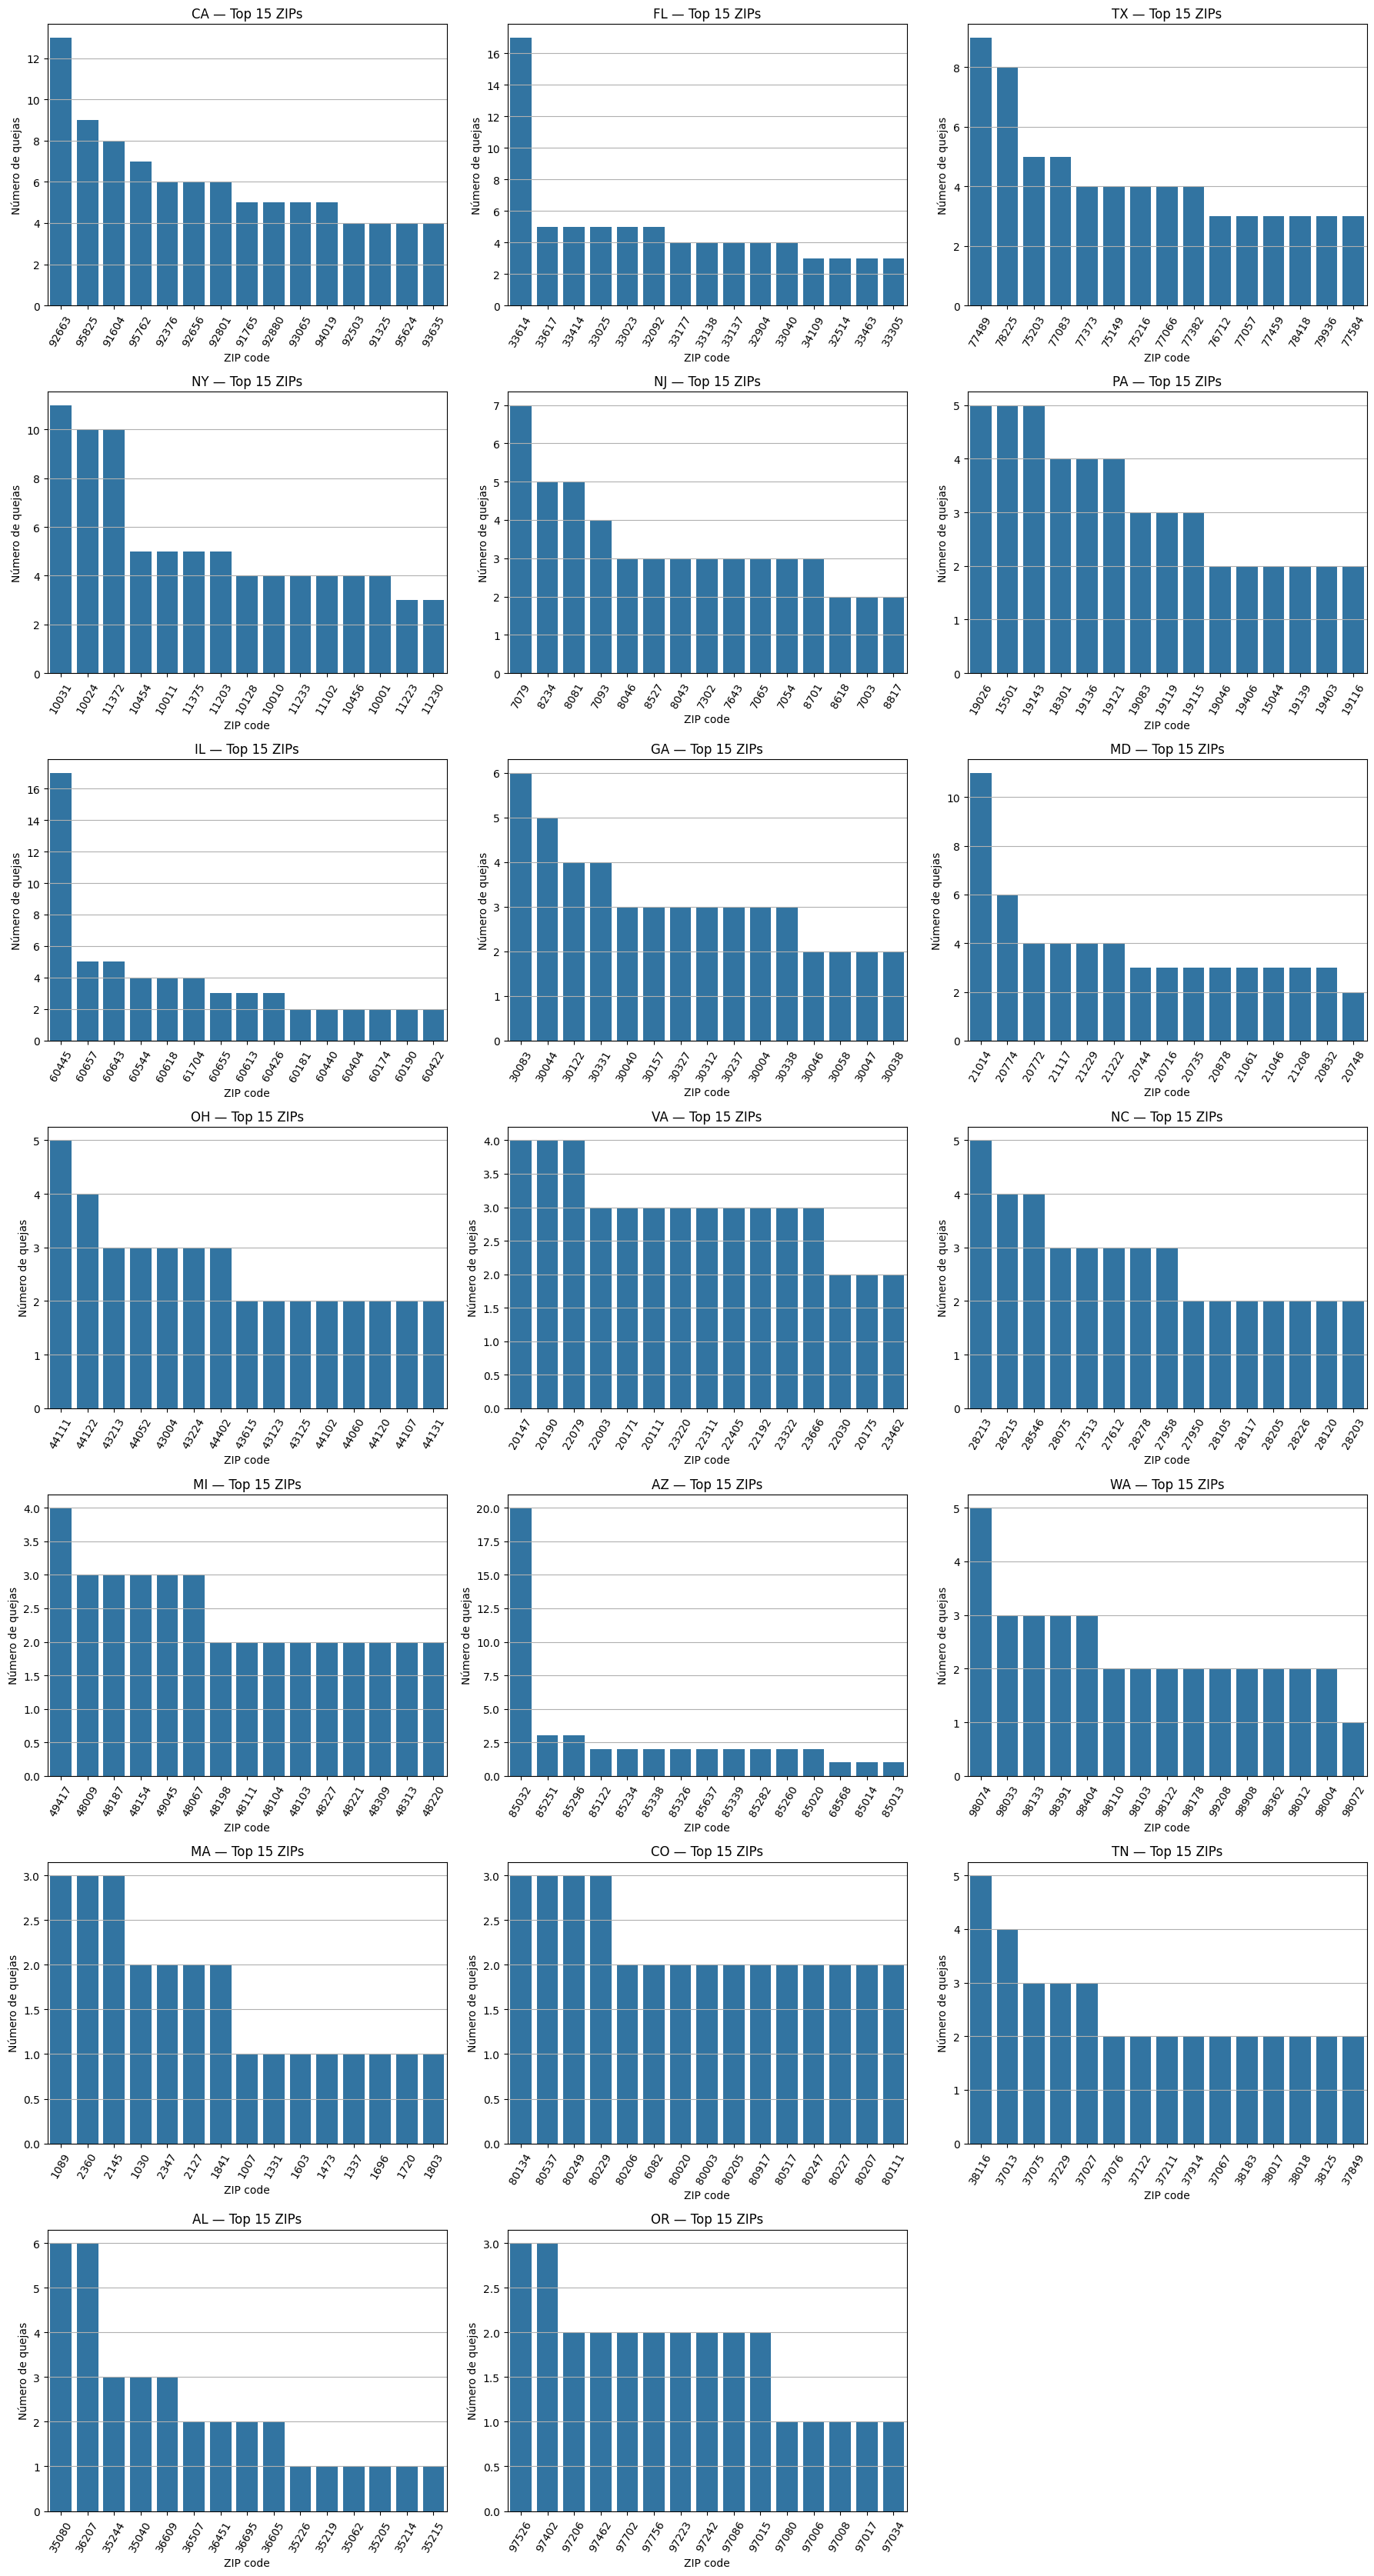

In [37]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parámetros editables
N_TOP_STATES = 20   # cuántos estados mostrar
M_TOP_ZIPS   = 15   # cuántos ZIPs por estado
EXCLUDE_NA_ZIP = True  # True = excluye ZIPs nulos; False = incluye y los etiqueta como "Unknown"

df_plot = df_model.copy()
df_plot["State"] = df_plot["State"].astype(str).str.strip()

# Filtrado opcional de ZIPs nulos
if EXCLUDE_NA_ZIP:
    df_plot = df_plot[df_plot["ZIP code"].notna()]

# Conteo por estado y ZIP (si incluimos nulos, mantenerlos en el groupby)
counts = (
    df_plot.groupby(["State", "ZIP code"], dropna=EXCLUDE_NA_ZIP)  # si no excluimos, cuenta también NaN
          .size()
          .reset_index(name="count")
)

# Top N estados por volumen total
state_totals = counts.groupby("State")["count"].sum().sort_values(ascending=False)
top_states = state_totals.head(N_TOP_STATES).index.tolist()

# Preparar grid de subplots
ncols = 3  # ajústalo si quieres 2 o 4
nrows = math.ceil(len(top_states) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.8*nrows), squeeze=False)

for i, state in enumerate(top_states):
    r, c = divmod(i, ncols)
    ax = axes[r][c]

    # Subtabla por estado, ordenada descendentemente y limitada al top M
    sub = (counts[counts["State"] == state]
           .sort_values("count", ascending=False)
           .head(M_TOP_ZIPS)
           .copy())

    # Etiquetas de ZIP: convertir a string solo para el eje X (sin modificar df_model)
    zip_labels = (
        sub["ZIP code"]
        .astype("Int64")        # mantiene nulos como <NA>
        .astype("string")       # para mostrar como texto
        .fillna("Unknown")      # solo si EXCLUDE_NA_ZIP=False aparecerán Unknown
    )

    # Dibujar respetando el orden de 'sub' (descendente)
    sns.barplot(x=zip_labels, y=sub["count"], ax=ax)
    ax.set_title(f"{state} — Top {M_TOP_ZIPS} ZIPs")
    ax.set_xlabel("ZIP code")
    ax.set_ylabel("Número de quejas")
    ax.tick_params(axis="x", rotation=60)

# Ocultar axes vacíos si no se llena el grid
for j in range(i + 1, nrows * ncols):
    r, c = divmod(j, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()


In [38]:
df_model

,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,days_to_company,target
2,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0,1
6,Consumer loan,Installment loan,Managing the loan or lease,NaN,OH,44241,"CashCall, Inc.",Closed with explanation,Yes,Yes,0,1
30,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,CT,6611,"CCS Financial Services, Inc.",Closed with explanation,Yes,Yes,0,1
42,Credit card,NaN,Delinquent account,NaN,PA,19406,Amex,Closed with explanation,Yes,Yes,0,1
89,Credit reporting,NaN,Incorrect information on credit report,Personal information,MI,48237,TransUnion,Closed with non-monetary relief,Yes,Yes,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28149,Credit reporting,NaN,Improper use of my credit report,Report improperly shared by CRC,MI,48622,Experian,Closed with explanation,Yes,No,6,0
28150,Credit card,NaN,Late fee,NaN,AR,72160,U.S. Bancorp,Closed with monetary relief,Yes,No,1,0
28151,Debt collection,NaN,Cont'd attempts collect debt not owed,Debt is not mine,TX,75201,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No,1,0
28153,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,MN,55105,Regions,Closed with non-monetary relief,Yes,No,1,0


In [39]:
to_drop = [c for c in ["ZIP code", "Consumer disputed?"] if c in df_model.columns]
df_model = df_model.drop(columns=to_drop).copy()
print("Columnas eliminadas:", to_drop)
df_model


Columnas eliminadas: ['ZIP code', 'Consumer disputed?']


,Product,Sub-product,Issue,Sub-issue,State,Company,Company response,Timely response?,days_to_company,target
2,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,RBS Citizens,Closed with explanation,Yes,0,1
6,Consumer loan,Installment loan,Managing the loan or lease,NaN,OH,"CashCall, Inc.",Closed with explanation,Yes,0,1
30,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,CT,"CCS Financial Services, Inc.",Closed with explanation,Yes,0,1
42,Credit card,NaN,Delinquent account,NaN,PA,Amex,Closed with explanation,Yes,0,1
89,Credit reporting,NaN,Incorrect information on credit report,Personal information,MI,TransUnion,Closed with non-monetary relief,Yes,0,1
...,...,...,...,...,...,...,...,...,...,...
28149,Credit reporting,NaN,Improper use of my credit report,Report improperly shared by CRC,MI,Experian,Closed with explanation,Yes,6,0
28150,Credit card,NaN,Late fee,NaN,AR,U.S. Bancorp,Closed with monetary relief,Yes,1,0
28151,Debt collection,NaN,Cont'd attempts collect debt not owed,Debt is not mine,TX,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,1,0
28153,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,MN,Regions,Closed with non-monetary relief,Yes,1,0


In [40]:
df_model["Timely response?"] = df_model["Timely response?"].cat.rename_categories({"Yes": 1, "No": 0}).astype("int8")


In [41]:
# Añade la categoría "Unknown" y rellena NaN en TODAS las columnas categóricas que tengan nulos
for c in df_model.select_dtypes(include="category").columns:
    if df_model[c].isna().any():
        df_model[c] = df_model[c].cat.add_categories("Unknown").fillna("Unknown")
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4678 entries, 2 to 28155
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Product           4678 non-null   category
 1   Sub-product       4678 non-null   category
 2   Issue             4678 non-null   category
 3   Sub-issue         4678 non-null   category
 4   State             4678 non-null   category
 5   Company           4678 non-null   category
 6   Company response  4678 non-null   category
 7   Timely response?  4678 non-null   int8    
 8   days_to_company   4678 non-null   Int64   
 9   target            4678 non-null   int64   
dtypes: Int64(1), category(7), int64(1), int8(1)
memory usage: 160.2 KB


In [42]:
import pandas as pd

cat_cols = df_model.select_dtypes(include=["category"]).columns.tolist()
num_cols = [c for c in df_model.select_dtypes(include=["number"]).columns if c != "target" and c != "Timely response?"]
bin_cols = [c for c in ["target", "Timely response?"] if c in df_model.columns]

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)
print("Binarias (0/1):", bin_cols)


Categóricas: ['Product', 'Sub-product', 'Issue', 'Sub-issue', 'State', 'Company', 'Company response']
Numéricas: ['days_to_company']
Binarias (0/1): ['target', 'Timely response?']


In [43]:
for b in bin_cols:
    for n in num_cols:
        r = df_model[n].astype(float).corr(df_model[b].astype(float))  # Pearson == point-biserial con 0/1
        print(f"Point-biserial (Pearson 0/1) {b} vs {n}: {r:.4f}")


Point-biserial (Pearson 0/1) target vs days_to_company: 0.0382
Point-biserial (Pearson 0/1) Timely response? vs days_to_company: 0.0063


In [44]:
from itertools import combinations

for a, b in combinations(bin_cols, 2):
    phi = df_model[a].astype(float).corr(df_model[b].astype(float))
    print(f"Phi (Pearson 0/1) {a} vs {b}: {phi:.4f}")

Phi (Pearson 0/1) target vs Timely response?: -0.0289


In [45]:
import numpy as np

def cramers_v_bias_corrected(x: pd.Series, y: pd.Series) -> float:
    confusion = pd.crosstab(x, y)
    n = confusion.to_numpy().sum()
    if n == 0:
        return np.nan
    row_sums = confusion.sum(axis=1).to_numpy()[:, None]
    col_sums = confusion.sum(axis=0).to_numpy()[None, :]
    expected = row_sums @ col_sums / n
    observed = confusion.to_numpy()
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2 = np.nansum((observed - expected) ** 2 / expected)
    phi2 = chi2 / n
    r, k = observed.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min(kcorr-1, rcorr-1)
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2corr / denom)

# target como categoría (para Cramér’s V)
target_cat = df_model["target"].map({0:"No", 1:"Yes"}).astype("category")

v_with_target = pd.Series({
    c: cramers_v_bias_corrected(df_model[c], target_cat)
    for c in cat_cols
}).sort_values(ascending=False)

print("Cramér’s V (categorical vs target):")
v_with_target


Cramér’s V (categorical vs target):


Company             0.189522
Issue               0.183647
Sub-issue           0.178023
Company response    0.138137
Product             0.123958
Sub-product         0.116461
State               0.037117
dtype: float64

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def bar_by_target(df, col, target="target", top=15, as_percent=True, figsize=(14,4)):
    """
    Dibuja dos barplots lado a lado para 'col' vs 'target':
      - Izquierda: distribución dentro de target=1
      - Derecha:   distribución dentro de target=0
    Ordena por la contribución en target=1 (desc).
    
    Params:
      col: columna categórica a analizar
      top: nº de categorías a mostrar (según top en target=1)
      as_percent: True -> porcentajes dentro de cada clase; False -> conteos
    """
    # Subset y casting ligero
    tmp = df[[col, target]].copy()
    # Si la columna es category la usamos tal cual (con "Unknown"), si no, la pasamos a string
    if tmp[col].dtype.name != "category":
        tmp[col] = tmp[col].astype(str)
    
    # Top categorías definidas por su presencia en target=1
    top_cats = (tmp.loc[tmp[target] == 1, col].value_counts().head(top).index.tolist())
    if len(top_cats) == 0:
        print(f"[Aviso] '{col}': no hay categorías para target=1.")
        return
    
    # Conteos por clase
    c1 = tmp.loc[tmp[target] == 1, col].value_counts()
    c0 = tmp.loc[tmp[target] == 0, col].value_counts()
    
    # Reindex a top_cats y ordenar por target=1 desc
    df1 = c1.reindex(top_cats, fill_value=0).reset_index()
    df0 = c0.reindex(top_cats, fill_value=0).reset_index()
    df1.columns = [col, "value"]
    df0.columns = [col, "value"]
    
    if as_percent:
        total1 = df1["value"].sum() or 1
        total0 = df0["value"].sum() or 1
        df1["value"] = df1["value"] / total1
        df0["value"] = df0["value"] / total0
        ylab = "Porcentaje dentro de la clase"
        fmt = lambda v: f"{100*v:.1f}%"
        sharey = True  # ambas van 0–1
    else:
        ylab = "Nº de casos"
        fmt = lambda v: f"{int(v)}"
        sharey = True  # misma escala para comparar volúmenes
        ymax = max(df1["value"].max(), df0["value"].max())
    
    # Orden (desc por target=1)
    order = df1.sort_values("value", ascending=False)[col].tolist()
    df1 = df1.set_index(col).loc[order].reset_index()
    df0 = df0.set_index(col).loc[order].reset_index()
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=sharey)
    
    sns.barplot(data=df1, x=col, y="value", ax=axes[0])
    axes[0].set_title(f"{col} | target=1 (Sí)")
    axes[0].set_xlabel(col); axes[0].set_ylabel(ylab)
    axes[0].tick_params(axis="x", rotation=30)
    
    sns.barplot(data=df0, x=col, y="value", ax=axes[1])
    axes[1].set_title(f"{col} | target=0 (No)")
    axes[1].set_xlabel(col); axes[1].set_ylabel("")
    axes[1].tick_params(axis="x", rotation=30)
    
    # Etiquetas encima de las barras
    for ax, df_plot in zip(axes, (df1, df0)):
        for p, v in zip(ax.patches, df_plot["value"].values):
            ax.annotate(fmt(v), (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', xytext=(0,3), textcoords='offset points', fontsize=8)
    
    if not as_percent:
        axes[0].set_ylim(0, ymax*1.1)
        axes[1].set_ylim(0, ymax*1.1)
    
    plt.tight_layout()
    plt.show()


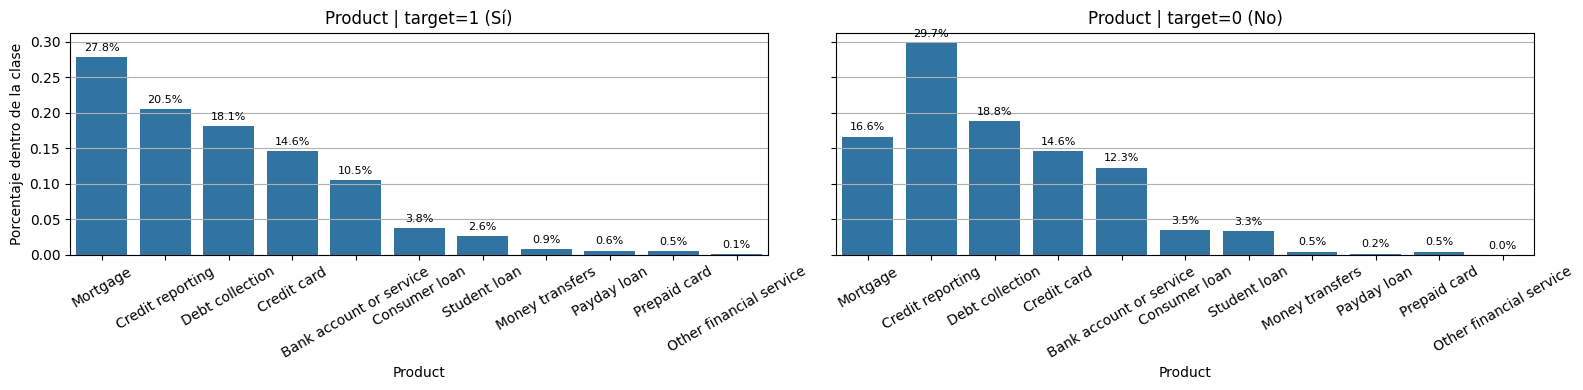

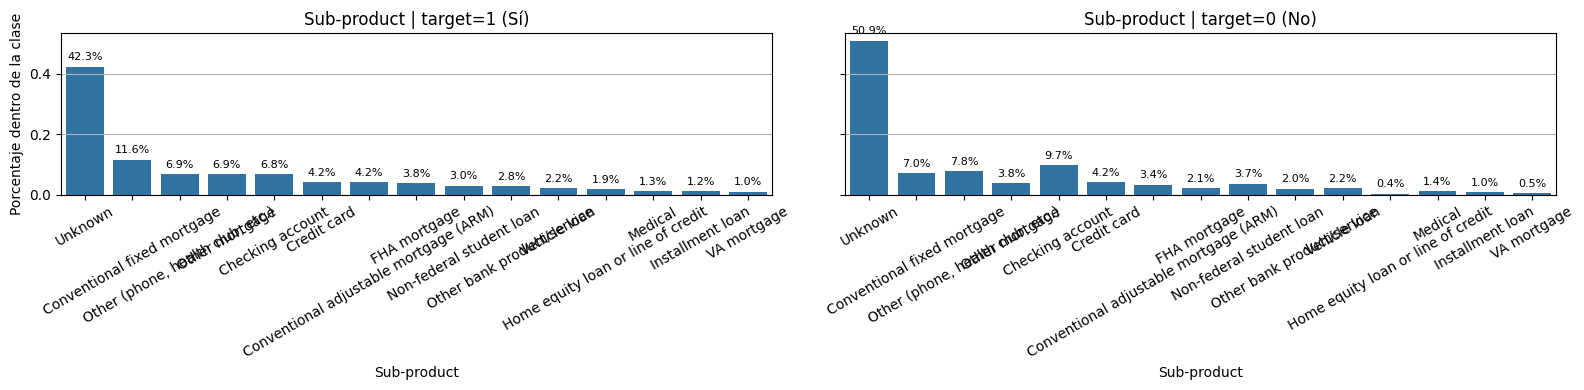

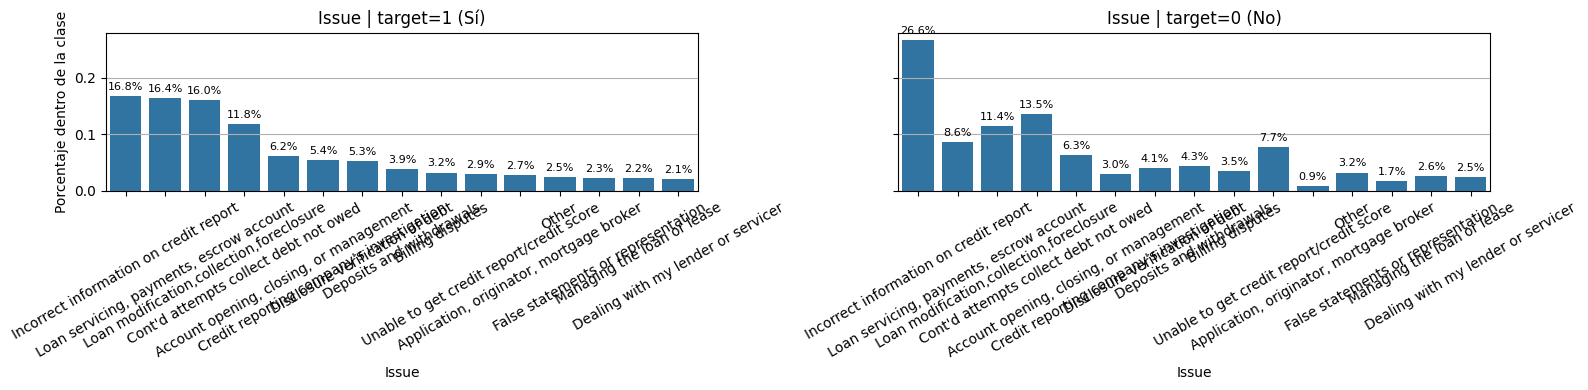

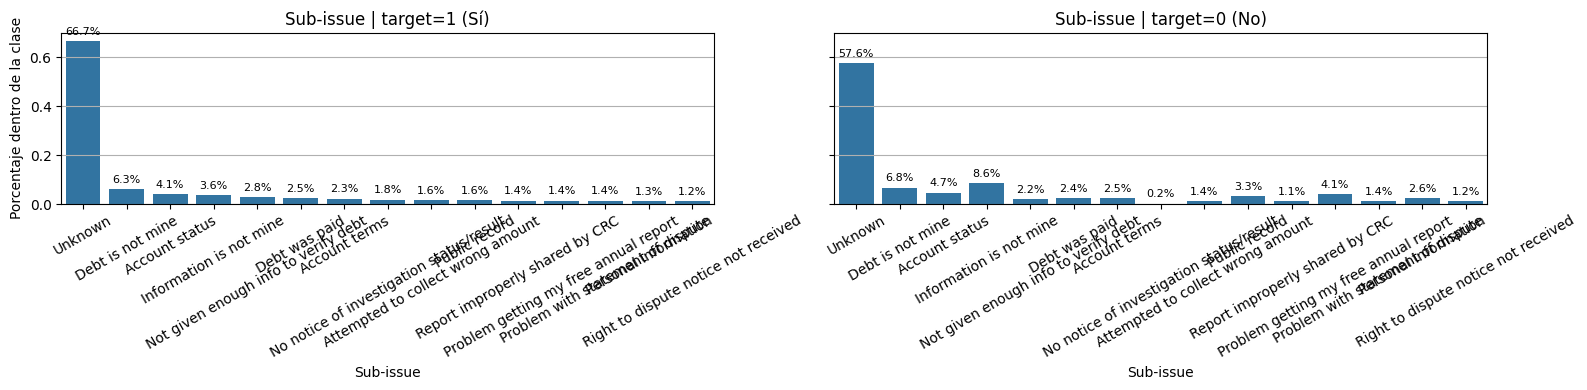

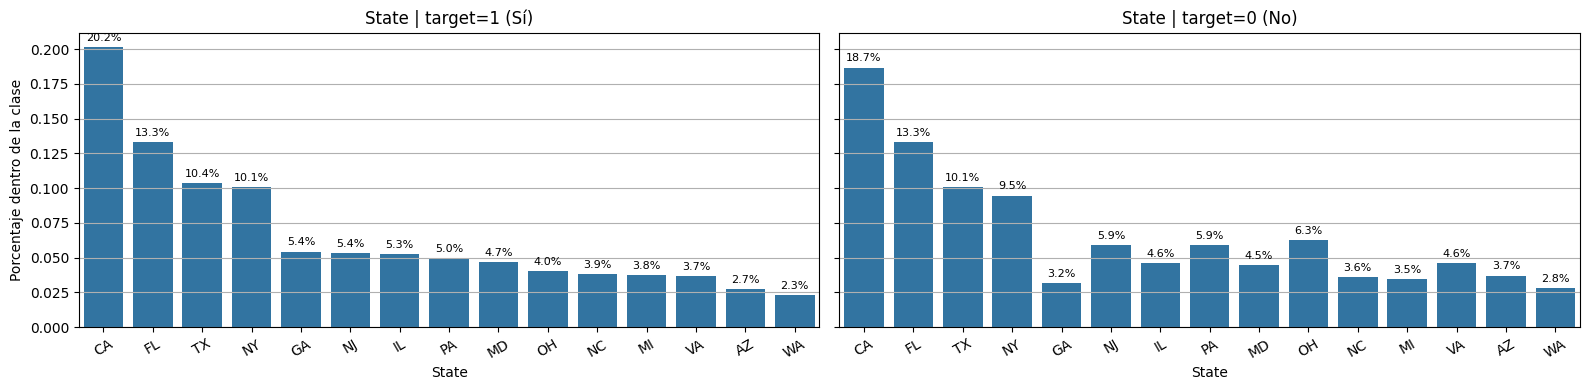

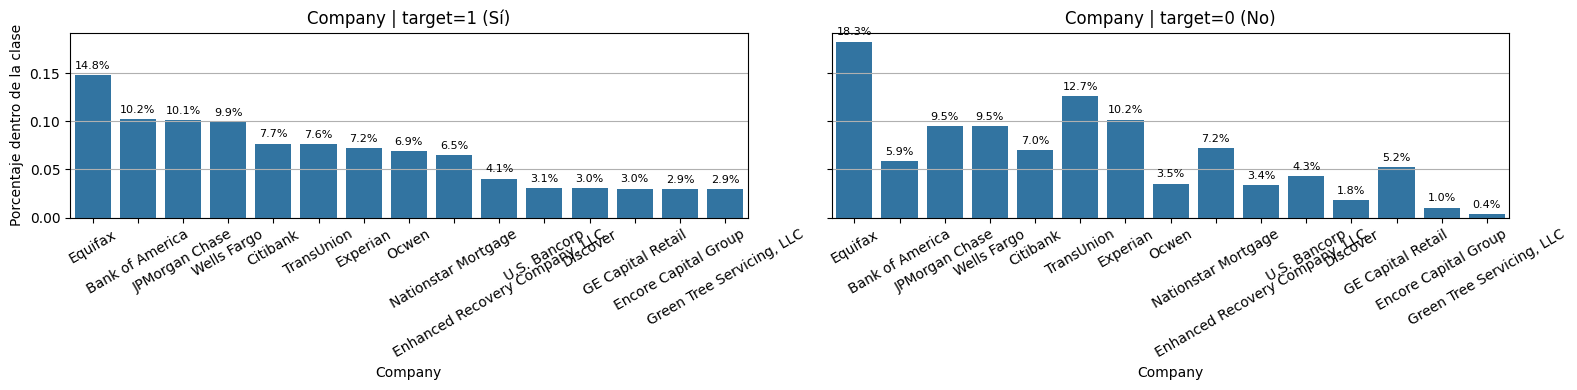

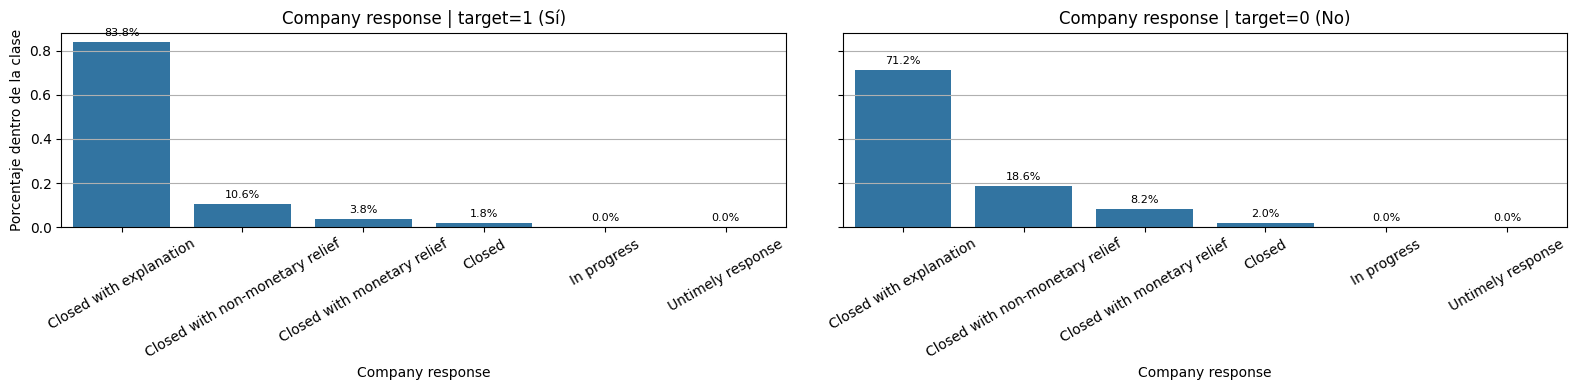

In [47]:
# Lista de columnas categóricas (excluye el target si fuese category)
cat_cols = df_model.select_dtypes(include=["category"]).columns.tolist()

# Recorremos y pintamos
for col in cat_cols:
    bar_by_target(df_model, col, target="target", top=15, as_percent=True, figsize=(16,4))


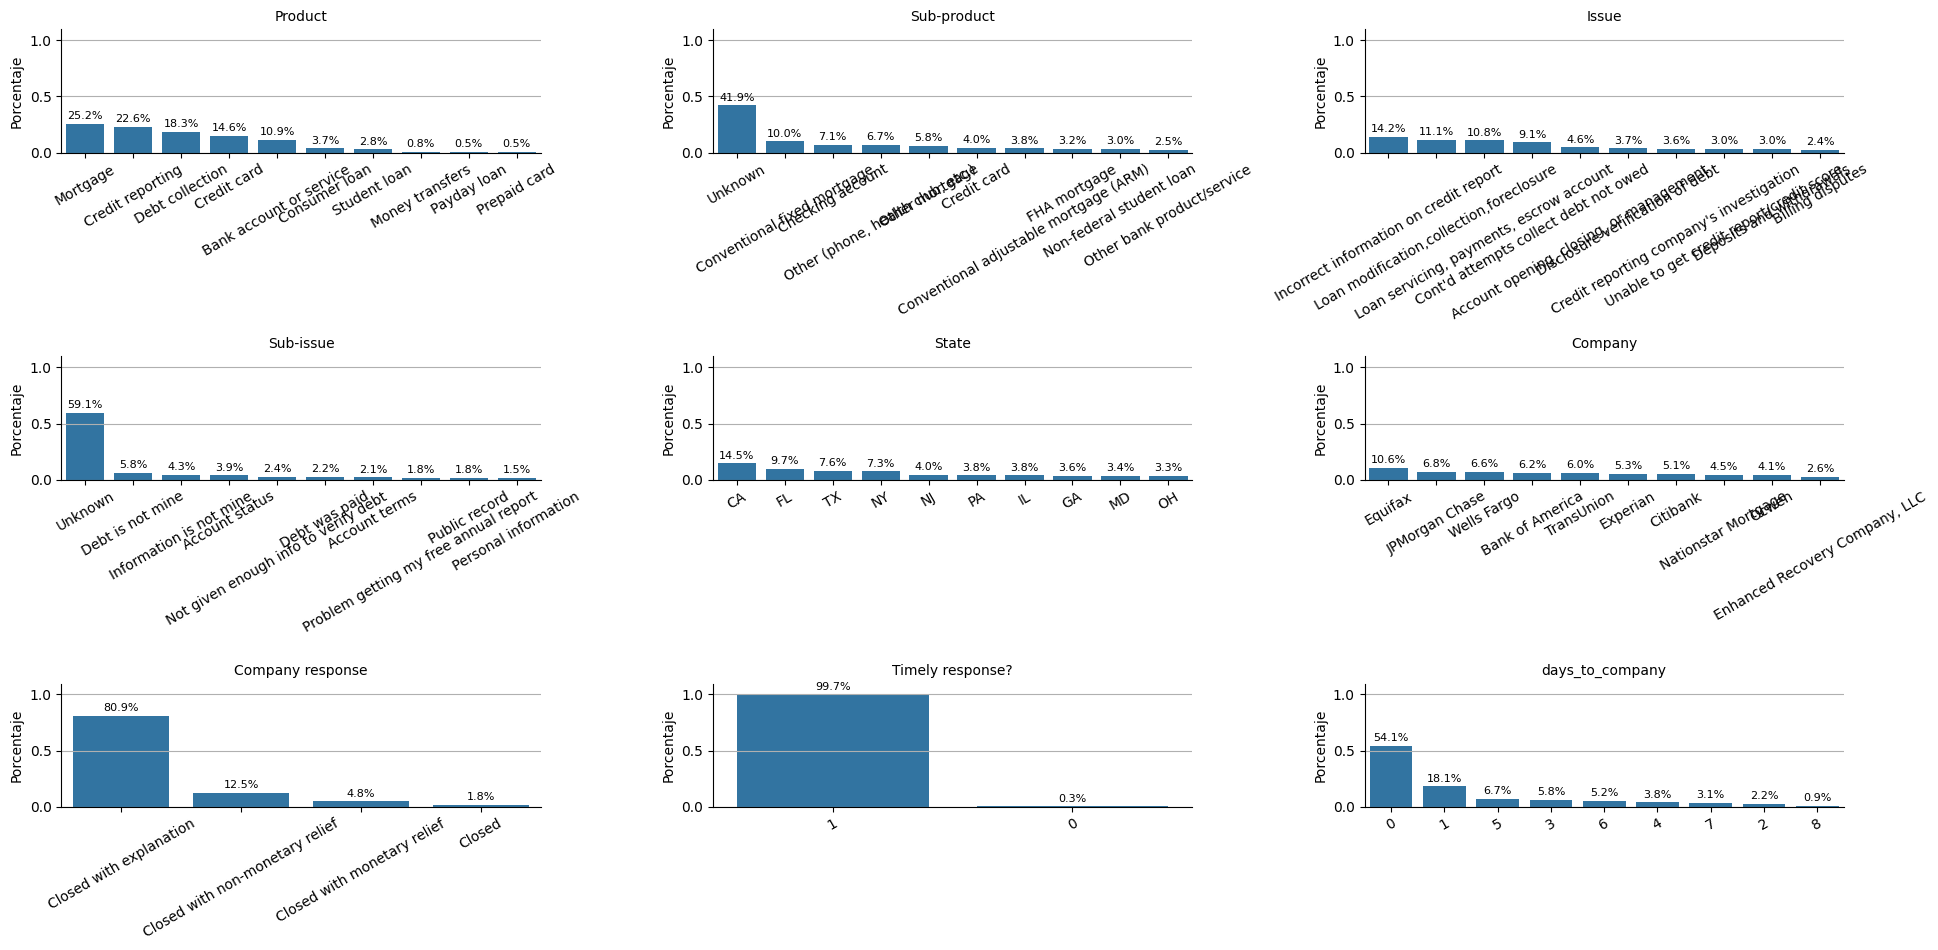

In [48]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_bars_all_columns_except_target(
    df,
    target="target",
    top=10,                 # Top N categorías por columna categórica
    ncols=3,                # 3 columnas -> con 9 plots queda 3x3
    width=6.5, height=3.2,  # tamaño de cada subplot (más ancho)
    rotate=35,              # rotación etiquetas
    num_bins=10,            # nº de bins para numéricas con mucha cardinalidad
    use_percent=True        # porcentaje en eje Y (suma 100% por gráfico)
):
    cols = [c for c in df.columns if c != target]
    total = len(df)
    assert total > 0, "El DataFrame está vacío."

    plots = []
    for col in cols:
        s = df[col]

        # Detectar si es numérica o categórica
        is_num = pd.api.types.is_numeric_dtype(s)

        if is_num:
            # Si tiene pocos valores distintos, lo tratamos como categórico directo
            nunq = s.nunique(dropna=False)
            if nunq <= 20:
                vc = s.astype("object").value_counts(dropna=False)
                series = (vc / total) if use_percent else vc
                series = series.sort_values(ascending=False)
            else:
                # Binning por cuantiles para barras legibles
                s_float = pd.to_numeric(s, errors="coerce")
                # Evitar errores si hay pocos valores no nulos
                valid = s_float.dropna()
                if len(valid) == 0:
                    series = pd.Series([], dtype=float)
                else:
                    # Si no podemos crear num_bins únicos por repetición, bajamos bins
                    q = min(num_bins, max(1, valid.nunique() - 1))
                    try:
                        binned = pd.qcut(valid, q=q, duplicates="drop")
                    except ValueError:
                        # fallback: bins iguales si cuantiles fallan
                        binned = pd.cut(valid, bins=min(num_bins, 10))
                    vc = binned.value_counts().sort_index()
                    series = (vc / total) if use_percent else vc
                    # Orden descendente por valor del bin
                    series = series.sort_values(ascending=False)
        else:
            # Categóricas: top N
            vc = s.astype("object").value_counts(dropna=False).head(top)
            series = (vc / total) if use_percent else vc
            series = series.sort_values(ascending=False)

        plots.append((col, series))

    n = len(plots)
    rows = math.ceil(n / ncols)
    fig, axes = plt.subplots(rows, ncols, figsize=(width*ncols, height*rows), squeeze=False)

    ymax_global = max((ser.max() for _, ser in plots if len(ser) > 0), default=1.0)
    if use_percent:
        ymax_global = min(1.0, ymax_global)

    for i, (col, vals) in enumerate(plots):
        r, c = divmod(i, ncols)
        ax = axes[r][c]

        if len(vals) == 0:
            ax.set_title(f"{col} (sin datos)")
            ax.axis("off")
            continue

        # Preparar datos para seaborn
        x_labels = vals.index.astype(str)
        y_vals = vals.values

        sns.barplot(x=x_labels, y=y_vals, ax=ax)
        ax.set_title(f"{col}", fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("Porcentaje" if use_percent else "Conteo")
        ax.tick_params(axis="x", rotation=rotate)
        ax.set_ylim(0, ymax_global * 1.10 if ymax_global > 0 else 1)

        # Etiquetas encima de barras
        for p, v in zip(ax.patches, y_vals):
            txt = f"{v*100:.1f}%" if use_percent else f"{int(v)}"
            ax.annotate(txt, (p.get_x()+p.get_width()/2, p.get_height()),
                        ha="center", va="bottom", fontsize=8, xytext=(0,2), textcoords="offset points")

        # Quitar spines para estética
        sns.despine(ax=ax)

    # Ocultar ejes vacíos si sobran
    for j in range(i+1, rows*ncols):
        r, c = divmod(j, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# === USO: con tu df_model (10 columnas, excluye 'target' => 9 plots 3x3) ===
plot_bars_all_columns_except_target(
    df_model,
    target="target",
    top=10,
    ncols=3,
    width=6.5, height=3.2,
    rotate=30,
    num_bins=10,
    use_percent=True
)


In [49]:
df_model

,Product,Sub-product,Issue,Sub-issue,State,Company,Company response,Timely response?,days_to_company,target
2,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Unknown,MA,RBS Citizens,Closed with explanation,1,0,1
6,Consumer loan,Installment loan,Managing the loan or lease,Unknown,OH,"CashCall, Inc.",Closed with explanation,1,0,1
30,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,CT,"CCS Financial Services, Inc.",Closed with explanation,1,0,1
42,Credit card,Unknown,Delinquent account,Unknown,PA,Amex,Closed with explanation,1,0,1
89,Credit reporting,Unknown,Incorrect information on credit report,Personal information,MI,TransUnion,Closed with non-monetary relief,1,0,1
...,...,...,...,...,...,...,...,...,...,...
28149,Credit reporting,Unknown,Improper use of my credit report,Report improperly shared by CRC,MI,Experian,Closed with explanation,1,6,0
28150,Credit card,Unknown,Late fee,Unknown,AR,U.S. Bancorp,Closed with monetary relief,1,1,0
28151,Debt collection,Unknown,Cont'd attempts collect debt not owed,Debt is not mine,TX,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,1,1,0
28153,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Unknown,MN,Regions,Closed with non-monetary relief,1,1,0


In [55]:
from pathlib import Path

# Asegurar carpeta ./data
Path("./../data").mkdir(exist_ok=True)

# Guardar CSV separado por ';'
out_path = Path("./../data") / "df_model_prepared.csv"
df_model.to_csv(out_path, sep=";", index=False, encoding="utf-8")

print(f"Guardado en: {out_path.resolve()}")

Guardado en: C:\Users\pc\Documents\Proyecto Final\data\df_model_prepared.csv
